## Домашнее задание 3.3 

### Импорт библиотек

In [260]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.errors import SettingWithCopyWarning

import warnings

### Глобальные настройки

In [261]:
warnings.filterwarnings("ignore", category=UserWarning)
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

np.random.seed(42)

sns.set_theme(style="darkgrid")

all_users = 2400
len_group = all_users // 2
count_users_A = 0, 1200
count_users_B = 1200, 2400

#### *1. Сгенерируйте искусственные данные для этого A/B-теста.*

In [262]:
group_A =  pd.DataFrame({
    'user_id': np.arange(*count_users_A),
    'group': 'A',
    'conversion': np.random.choice([0, 1], size=len_group, p=[0.5, 0.5])
})

group_B =  pd.DataFrame({
    'user_id': np.arange(*count_users_B),
    'group': 'B',
    'conversion': np.random.choice([0, 1], size=len_group, p=[0.45, 0.55])
})

test_data = pd.concat([group_A, group_B], ignore_index=True)

#### *2. Проведите бутстрап-анализ для оценки различий в средних коэффициентах конверсии между двумя группами.*

In [263]:
def bootstrap_means(test_data, n_bootstrap_samples=10000):
    bootstrap_sample_means = []
    for _ in range(n_bootstrap_samples):
        bootstrap_sample = np.random.choice(test_data, size=all_users, replace=True)
        bootstrap_sample_means.append(bootstrap_sample.mean())
    return np.array(bootstrap_sample_means)

bootstrap_means_A = bootstrap_means(test_data.loc[test_data['group'] == 'A', 'conversion'])
bootstrap_means_B = bootstrap_means(test_data.loc[test_data['group'] == 'B', 'conversion'])

boot_diff_means = bootstrap_means_B - bootstrap_means_A

blowout = np.percentile(boot_diff_means, [1, 99])
print('99% доверительный интервал для разницы в средних: ', blowout)

99% доверительный интервал для разницы в средних:  [0.01541667 0.0825    ]


#### *3. Проведите тест Хи-квадрат для оценки значимости различий в коэффициентах конверсии между двумя группами.*

In [264]:
contingency_table = pd.crosstab(test_data['group'], test_data['conversion'])
chi2, p_value, _, _ = chi2_contingency(contingency_table)

print(f"Chi2: {chi2}, p-value: {p_value}")

Chi2: 5.633618051916425, p-value: 0.017619229131454067


#### *4. Сгенерируйте искусственные метки времени для каждого пользователя, распределенные равномерно в течение 2023 года.*

In [265]:
date_range = pd.date_range(start='2023-01-01', end='2023-12-31', periods=all_users)
test_data['timestamp'] = np.random.choice(date_range, all_users, replace=False)

display(test_data.head(3))
display(test_data.tail(3))

,user_id,group,conversion,timestamp
0,0,A,0,2023-10-29 18:58:40.466861192
1,1,A,1,2023-05-17 20:38:54.972905378
2,2,A,1,2023-04-19 00:45:37.140475198


,user_id,group,conversion,timestamp
2397,2397,B,0,2023-11-02 06:43:58.099208004
2398,2398,B,1,2023-12-26 03:28:17.207169656
2399,2399,B,1,2023-02-20 12:37:30.937890788


#### *5. Сгенерируйте искусственные признаки «месяц» и «год» на основе этих меток времени.*

In [266]:
test_data['month'] = test_data['timestamp'].dt.month
test_data['year'] = test_data['timestamp'].dt.year

display(test_data.head(3))
display(test_data.tail(3))

,user_id,group,conversion,timestamp,month,year
0,0,A,0,2023-10-29 18:58:40.466861192,10,2023
1,1,A,1,2023-05-17 20:38:54.972905378,5,2023
2,2,A,1,2023-04-19 00:45:37.140475198,4,2023


,user_id,group,conversion,timestamp,month,year
2397,2397,B,0,2023-11-02 06:43:58.099208004,11,2023
2398,2398,B,1,2023-12-26 03:28:17.207169656,12,2023
2399,2399,B,1,2023-02-20 12:37:30.937890788,2,2023


#### *6. Постройте графики, показывающие изменение средних коэффициентов конверсии в течение года по месяцам и для всего года.*

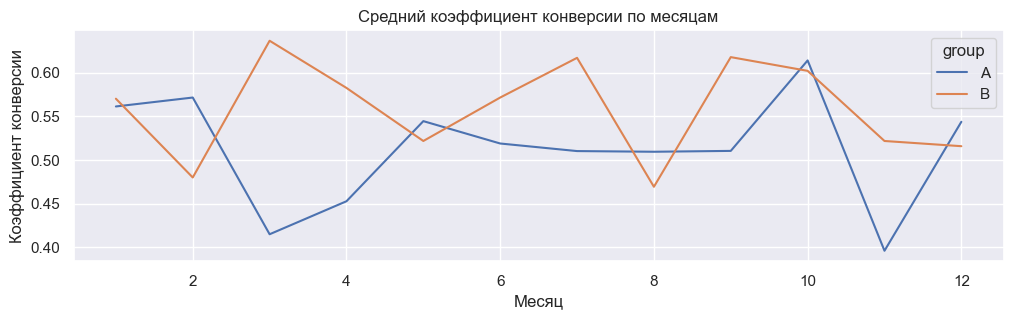

In [267]:
mean_conversion = test_data.groupby(['group', 'month']).mean()['conversion'].reset_index()

plt.figure(figsize=(12, 3))
sns.lineplot(data=mean_conversion, x='month', y='conversion', hue='group')

plt.title('Средний коэффициент конверсии по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Коэффициент конверсии')

plt.show()

#### *7. Напишите вывод по результатам эксперимента.*

Новый дизайн сайта показал улучшение в коэффициентах конверсии , и статистические тесты подтвердили, что это улучшение значимо.<br> Рекомендуется внедрить новый дизайн для всех пользователей.<br>

1. **Бутстрап-анализ** показал, доверительный интервал (99%) для разницы в средних коэффициентах конверсии не включает 0, что указывает на значительное различие между группами A и B.
2. **Тест Хи-квадрат** также показал значительное различие (p-value < 0.05), что дополнительно подтверждает значимость изменений.
3. **Анализ временных меток** показывает, что улучшения в коэффициентах конверсии группы B по сравнению с группой A наблюдаются в разные месяцы, что можно увидеть на графике.